# Image Processing and Computing the Mean Curvature of Objects in .tif File Images

Here, we load `.tif` file images into python. The loaded files are visualized in subplots as seperate channels in which each channel can have the following properities modified: `brightness`, `contrast`, `gain`, and `bias`. 

The image of the given channel is then masked and segmented. We focused on the image files 'blobs.tif' and 'FluorescentCells.tif' for this pilot code, with the latter primarily focusing on the third channel containing the fluorescently labeled cells' nuclei. In the code, they are referred to as `img1` and `img2[2]`, where `[2]` denotes the third channel.

Finally, we compute the mean curvature of each blob using the masked image channel. 

## Importing packages and modules implemented in the code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap                                      # Colormap objects based on lookup tables using linear segments
from skimage import data, io, filters, measure, segmentation, feature, morphology, viewer  # A collection of algorithms for image processing
from scipy import ndimage as ndi                                                           # A collection of functions for multidimensional image processing
from skimage.segmentation import clear_border as clear_border                              # Create a checkerboard level set with binary values
from skimage.measure import label, regionprops                                             


import masking_mod as mskf #the module we made to segment tif images 
import curvature_module as crvf #the module to detect curvature 

C:\Users\bvanherck\Anaconda3\lib\site-packages\skimage\viewer\utils\__init__.py:1: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  from .core import *


## Loading and visualizing images from .tif file format


In [2]:
## Load images
img1 = io.imread("Images/blobs.tif", plugin="tifffile")
img2 = io.imread("Images/FluorescentCells.tif", plugin="tifffile").T  # .T to transpose image with multple channels (x, y, z) -> (z, y, x)
img3 = io.imread("Images/FluorescentCells2.tif", plugin="tifffile").T # .T to transpose image with multple channels (x, y, z) -> (z, y, x)

#ch1, ch2, ch3 = img2[0], img2[1], img2[2]

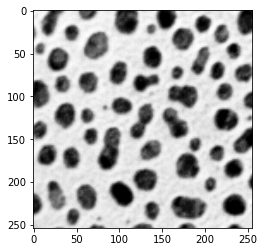

In [3]:
## Visualize the channels of the image as seperate channels in a subplot
plt.imshow(img1, cmap="Greys")
plt.show()

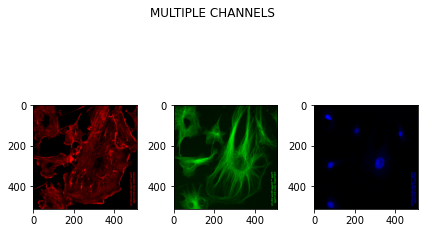

In [4]:
## Setting color dictionaries for visualization
red = [(0, 0, 0), (1, 0, 0)]
green = [(0, 0, 0), (0, 1, 0)]
blue = [(0, 0, 0), (0, 0, 1)]
yellow = [(0, 0, 0), (1, 1, 0)]
magenta = [(0, 0, 0), (1, 0, 1)]
cyan = [(0, 0, 0), (0, 1, 1)]

## setting color maps for visualization
lut_red = LinearSegmentedColormap.from_list("Custom", red, N=256)
lut_green = LinearSegmentedColormap.from_list("Custom", green, N=256)
lut_blue = LinearSegmentedColormap.from_list("Custom", blue, N=256)
lut_cyan = LinearSegmentedColormap.from_list("Custom", cyan, N=256)
lut_magenta = LinearSegmentedColormap.from_list("Custom", magenta, N=256)
lut_yellow = LinearSegmentedColormap.from_list("Custom", yellow, N=256)

## Subplot for the 3 channels in img2 
fig, axs = plt.subplots(1, 3)
fig.suptitle("MULTIPLE CHANNELS")
axs[0].imshow(img2[0], cmap=lut_red)
axs[1].imshow(img2[1], cmap=lut_green)
axs[2].imshow(img2[2], cmap=lut_blue)
fig.tight_layout()
plt.show()

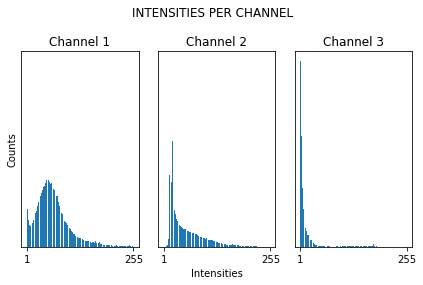

In [5]:
## Display historgrams as a 1D array
ch1_conc = np.concatenate(img2[0])
ch2_conc = np.concatenate(img2[1])
ch3_conc = np.concatenate(img2[2])

hist1 = np.histogram(ch1_conc, bins=255)
hist2 = np.histogram(ch2_conc, bins=255)
hist3 = np.histogram(ch3_conc, bins=255)

## Plots the associated intensity histagrams
fig1, axs = plt.subplots(1, 3)
fig1.suptitle("INTENSITIES PER CHANNEL")
axs[0].bar(hist1[1][1:-1], hist1[0][1:])
axs[0].set_title('Channel 1')
axs[0].set_ylabel('Counts')
axs[0].set_yticks([])
axs[0].set_xticks([1, 255])

axs[1].bar(hist2[1][1:-1], hist2[0][1:])
axs[1].set_title('Channel 2')
axs[1].set_xlabel('Intensities')
axs[1].set_yticks([])
axs[1].set_xticks([1, 255])

axs[2].bar(hist3[1][1:-1], hist3[0][1:])
axs[2].set_title('Channel 3')
axs[2].set_yticks([])
axs[2].set_xticks([1, 255]);
fig1.tight_layout()
plt.show()

### Changing brightness and contrast
For each pixel `f` with coordenates `(i,j)` the function to change brightness and contrast is:

$$g(i,j)=\alpha\cdot f(i,j) + \beta$$

where $\alpha$ is the gain and $\beta$ is the bias

In [6]:
def change_brightness_contrast(alpha, beta, channel):
    
    ch1_conc = np.concatenate(channel)
    hist1 = np.histogram(channel, bins=255)
    
    alpha, beta = float(alpha), int(beta)
    new_ch1 = alpha * channel - beta
    binwidth = 255 / (255 + abs(beta))
    
    if beta > 0:
        new_ch1[new_ch1<0]=0
        new_ch1_conc = np.concatenate(new_ch1)
        new_ch1_hist = np.histogram(new_ch1_conc, bins=np.arange(0, 255 -binwidth, binwidth))
    else:
        new_ch1[new_ch1>255]=255
        new_ch1_conc = np.concatenate(new_ch1)
        new_ch1_hist = np.histogram(new_ch1_conc, bins=np.arange(np.amin(new_ch1)- binwidth, np.amax(new_ch1) + binwidth, binwidth))
    
    fig, axs = plt.subplots(2, 2)
    axs[0][0].set_title("Original")
    axs[0][0].imshow(channel, cmap=lut_red)
    axs[0][0].set_xticks([])
    axs[0][0].set_yticks([])
    axs[0][1].set_title("Contrast and brigthness changed")
    new_red = [(-beta / 256, 0, 0), (1, 0, 0)]
    new_lut_red = LinearSegmentedColormap.from_list("Custom", new_red, N=256)
    axs[0][1].imshow(new_ch1, cmap=new_lut_red)
    axs[0][1].set_xticks([])
    axs[0][1].set_yticks([])
    axs[1][0].bar(hist1[1][1:-1], hist1[0][1:])
    axs[1][0].set_xticks([1, 255])
    axs[1][0].set_yticks([])
    axs[1][1].bar(new_ch1_hist[1][1:-1], new_ch1_hist[0][1:])
    axs[1][1].set_xticks([1, 255])
    axs[1][1].set_yticks([])

Gain:5
Bias:10


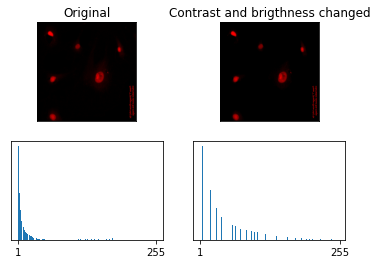

In [11]:
alpha = input("Gain:")
beta = input("Bias:")

change_brightness_contrast(alpha, beta, img2[2])

## Segment and mask the image
The original code for the masking module (`masking_mod.py`) can be found at: 

- [image_processing1.ipynb](https://github.com/lukepolson/youtube_channel/blob/main/Python%20Tutorial%20Series/image_processing1.ipynb)


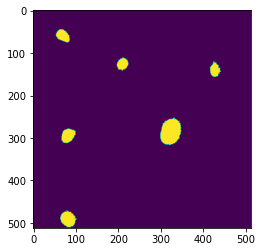

In [8]:
## Use masking function on specified image
img2_ch3_masked = mskf.masking(img2[2], threshold=50, num_labels=6)#(img2[2]

## Visualize the mask on the image
plt.imshow(img2_ch3_masked)

## Calculate the mean curvature

To calculate the curvate we implement module `curvature_module.py`. The code has been adapted from:

- [Exercise 11 - Segmentation](https://ojskrede.github.io/inf4300/exercises/week_11/)

- [Identifying and Measuring the Curvature of Caulobacter Cells](https://github.com/jmschabdach/caulobacter-curvature/blob/master/Identifying%20and%20Measuring%20the%20Curvature%20of%20Caulobacter%20Cells.ipynb)

- [Python edge detection and curvature calculation](https://stackoverflow.com/questions/9137216/python-edge-detection-and-curvature-calculation)

- [Scikit-Image: Image filtering](https://scikit-image.org/skimage-tutorials/lectures/1_image_filters.html)

- [Image Segmentation using Python’s scikit-image module.](https://towardsdatascience.com/image-segmentation-using-pythons-scikit-image-module-533a61ecc980)   

C:\Users\bvanherck\Documents\programming course\Casimir-programming\curvature_module.py:63: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_max = feature.peak_local_max(distance, indices=False, footprint=np.ones((3, 3)), labels=cleaned_edges)


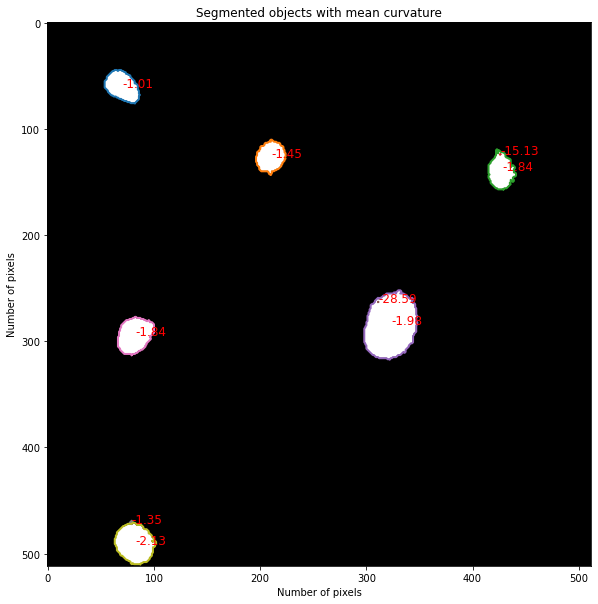

In [9]:
## Detecting edges for empty blobs using a Gaussian smoothing
#cleaned_edges = crvf.preprocess_image(img1, sigma=3, dilation_radius=1, min_size=100)

## Plotting the img2[2] with solid blobs using the segmentation and mask from above
cleaned_labels = crvf.segment_objects(img2_ch3_masked)
crvf.plot_segmented_objects(img2_ch3_masked, cleaned_labels, contour_threshold=0.5)

C:\Users\bvanherck\Documents\programming course\Casimir-programming\curvature_module.py:46: FutureWarning: `selem` is a deprecated argument name for `dilation`. It will be removed in version 1.0. Please use `footprint` instead.
  dilated_edges = morphology.dilation(edges, selem=morphology.disk(dilation_radius))
C:\Users\bvanherck\Documents\programming course\Casimir-programming\curvature_module.py:63: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_max = feature.peak_local_max(distance, indices=False, footprint=np.ones((3, 3)), labels=cleaned_edges)


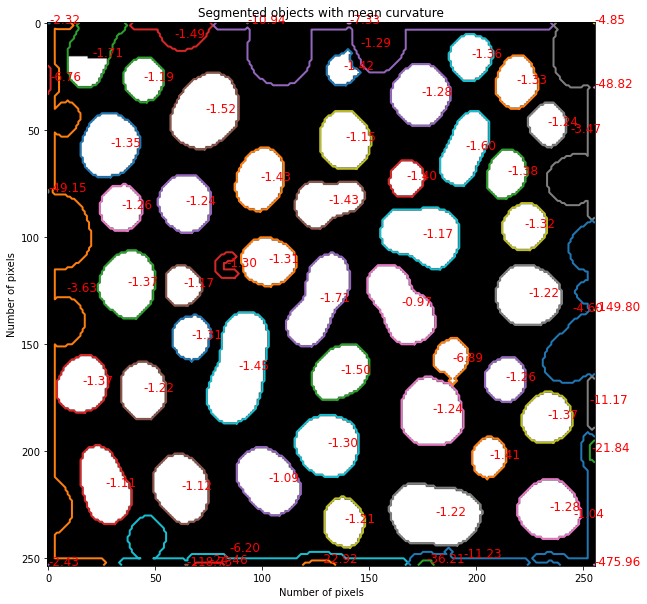

In [10]:
## Detecting edges for empty blobs using a Gaussian smoothing with the segmentation mask
cleaned_edges = crvf.preprocess_image(img1, sigma=3, dilation_radius=1, min_size=10)
cleaned_labels_img1 = crvf.segment_objects(cleaned_edges)
img1_masked = mskf.masking(cleaned_labels_img1, threshold=20, num_labels=-1)


## Plot the image with blobs (img1) using the segmentation and mask from above and the original image is below
crvf.plot_segmented_objects(img1_masked, cleaned_labels_img1, contour_threshold=0.5)